In [1]:
from IPython.display import Image

지금까지는 스트림 데이터를 처리하기 위한 아키텍처를 만들었다. 이제 프로세싱을 완료한 데이터를 클라이언트에 어떻게 제공할지 생각해봐야 한다. 여기서 선택할 수 있는 기술과 구축 방법이 너무 많아서 많은 생각이 들 수 있다. 이 단계의 핵심은 사용자가 API로 접근하여 실시간 분석 데이터를 조회할 수 있는 애플리케이션을 구축하는 것이다. 이런 유형의 API에 접근할 수 있으면 실시간으로 데이터를 확인하고 작업해서 비즈니스 가치를 신속하게 얻을 수 있고, 개발에 힘을 실어줄 수 있다.  

통신 패턴과 오류 처리 방법, 다양한 프로토콜을 이해하고 스트리밍 데이터 API 구축법을 알아보자.

# 네트워크 통신 패턴

스트림 시스템인 데이터를 연속적으로 처리하지만, 클라이언트와의 네트워크 통신은 꼭 그럴 필요가 없다. 그보다 API를 통해 클라이언트가 데이터를 가져가게 할지, 서버가 클라이언트로 푸시할지 고민해야 한다. 한편, Push랑 Pull 말고도 RMI/RPC, Simple messaging, Publish-Subscribe 등의 패턴이 있다.

### 데이터 동기화

데이터 동기화란 API의 DB 또는 저장소와 클라이언트를 동기화하는 것이다. 이때 스티리밍 데이터 API가 사용된다. 이 방식은 서버에서 스티리밍 분석을 마치고 로컬에 저장된 데이터의 변경을 감지해 클라이언트에 업데이트된 데이터를 보내는 방식이다.  

패턴은 2단계로 나뉜다. 클라이언트가 처음 API로 연결될 때 분석이 끝난 데이터를 요청하고, 이후 변경사항은 클라이언트로 push하거나 가져오는 방식으로 진행된다. 이 방법은 프로토콜이 가깝고 개발하기 쉬운 API며, 조회하기 좋다는 장점이 있지만 데이터 용량으로 인한 대역폭을 크게 만들어야 하는 등의 단점이 있다. 

### RMI/RPC (Remote Method Invocation/Remote Procedure Call)

이 패턴은 API 서버에 새로운 데이터가 도착하거나 클라이언트가 요구하는 데이터가 도착했을 때, 클라이언트에 이씨는 method를 호출하는 방식이다. 스트리밍 데이터 API 서버가 분석 단계에 처리 완료된 데이터가 저장소에 저장되었는지 모니터링하고, 변경사항이 발견되면 method를 호출해 데이터를 전송한다.  

이 방법도 매우 간단한 프로토콜이며 직관적이고, 클라이언트의 엔드포인트만 알면 개발이 가능하다. 다만 장애를 감지하기 매우 어렵고, 발생했을 때 API 서버가 할 수 있는게 없다.

### Simple Messaging

이 패턴은 클라이언트가 스트리밍 API 서버에 가장 최근 데이터를 요청한다. 이때 데이터가 변경된 경우에만 스트리밍 API 서버를 호출하도록 설정할 수 있다. 그러면 API는 저장소에서 데이터를 가져와 클라이언트로 전달한다.  

이 방법도 역시 간단한 프로토콜을 사용하며, Consumer가 API를 호출할 수 있고, 클라이언트가 최신 데이터만 받을 수 있다는 장점이 있다. API가 클라이언트 상태를 추적할 필요도 없다. 다만 클라이언트가 계속 신규 데이터를 요청하기에 통신량이 많은 상태를 유지해야 하고, 전송 용량이 갑자기 커지는 순간이 오면 장애가 발생할 수도 있다.

### Publish/Subscribe

이 패턴은 클라이언트가 특정 채널을 구독하고, API는 데이터가 변경될 때 해당 채널을 구독하고 있는 클라이언트들에게 메시지를 보낸다. 스트리밍 API는 클라이언트들의 상태를 관리하고, 저장소 데이터가 변경되면 해당 채널과 연결된 클라이언트에게 알림을 날린다.  

이 방식은 클라이언트와 스트리밍 API의 부하를 줄일 수 잇고, 요청과 응답을 계속해서 주고받을 필요가 없다. 따라서 리소스 낭비가 적다. 이 패턴은 점점 더 인기가 많아지고 있으며, 빠른 응답이 필요한 Reactive program이나 스트리밍 시스템 등에서 활용된다. 대신 API 구현을 위한 복잡한 프로토콜이 필요하며, API 서버에 분산저장해 장애를 예방해야 한다.

# 프로토콜 방식

독자적인 스트리밍 API를 개발할 수도 있지만, 그러려면 기존의 프로토콜에 대한 이해가 필요하다. 각 프로토콜들은 메시지 업데이트 빈도, 통신 방향, 메시지 지연 시간, 효율성, 내결함성/신뢰성 등의 특징을 갖고 있다.

### Webhook

공식적인 W3C 표준은 아니지만, 새로운 데이터가 도착하거나 클라이언트 호출을 위해 HTTP 엔드포인트로 호출하는 방식으로 많이 사용되어 왔다.  

클라이언트가 HTTP POST로 콜백 등록을 위한 요청을 보내면 콜백 정보가 저장되고, 스트리밍 API는 정보에 변경사항이 생기면 모든 콜백을 호출한다.  

- **메시지 업데이트 빈도** : 업데이트 전송 빈도는 낮아 전송량이 많아도 활용할 수 있지만 텍스트 기반의 HTTP 통신 특성과 오버헤드를 생각하면 업데이트 빈도가 많은 경우에는 적합하지 않다. 
- **통신 방향** : 항상 서버에서 클라이언트로 이동한다.
- **메시지 지연 시간** : 메시지 지연 시간은 평균 수준이다.  HTTP 압축이나 Chunking을 쓸 수도 있다. 
- **효율성** : 스티리밍 API 관점에서 이 프로토콜은 매우 효율적이다. 
- **내결함성/신뢰성**: 딱히 내결함성도 없고 신뢰성도 없다. 구현은 개발자 몫이다. HTTP POST가 실패하면 어떻게 할건지 고민해야 한다. POST 성공 여부 확인을 위해 GET을 만들 수 있지만, 확인 요청 실패에 대한 처리도 해야하므로 복잡성이 증가한다.

### HTTP Long Pooling

클라이언트와 서버가 네트워크 통신이 맺어진 상태로 데이터를 지속적으로 클라이언트로 보낸다. 클라이언트가 통신 요청을 하면 서버와 연결된 상태를 유지하며, 전송할 데이터가 생기면 지속적으로 통신해 전송한다. 스트리밍 API가 모든 클라이언트에 네트워크를 연결한 상태를 유지해야 한다.  

클라이언트의 웹개발 비동기 프로그래밍 유행에 따른 AJAX의 사용 증가에 따라 많이 활용된다. 최초의 웹 기반 채팅 어플에서 많이 활용했다. 거의 모든 프로그래밍 언어에서 구현할 수 있고, 라즈베리파이 같은 작은 하드웨어 장치에도 적용할 수 있다.  

- **메시지 업데이트 빈도** : HTTP 롱풀링은 통신빈도가 높더라도 이슈가 없다. 다만 업데이트 빈도가 높으면 오버헤드가 많이 발생할 가능성이 있다.
- **통신 방향** : 클라이언트와 서버가 연결되고 나면 원하는 데이터를 요청해 응답을 받을 수 있다.
- **메시지 지연 시간** : 평균적이다.
- **효율성** : 가장 효율적인 프로토콜은 아니다.연결을 계속 맺고 있다가 요청할 때 즉시 통신을 하므로 스트리밍 APLI의 네트워크 연결 개수를 알아야 하고, 클라이언트에서 접속을 끊었을 때 다시 연결할 방법도 고려해야 한다.
- **내결함성/신뢰성** : 내결함성과 신뢰성 둘다 없다. 이를 보장하기 위해 개발자는 추가 개발을 해야 한다. 유실이 되지 않으려면 어떻게 할지, API 서버 부하를 막기 위해 로드밸런스를 어떻게 적용할 수 있을지 등이다.  

### Server Sent Events

HTTP 롱풀링을 개선하기 위해 개발된 W3C 권장 프로토콜이다. SSE를 사용하면 클라이언트가 지속적으로 네트워크가 연결되고 끊기는 부분에서 발생하는 비효율적인 통신 방식을 해결할 수 있다. 그리고 모바일 디바이스와 같은 리소스가 제한된 장치를 사용할 때 푸시 프록시 서버를 사용해 장치가 유휴 상태여도 메시지를 푸시할 수 있다. 따라서 전력을 아낄 수 있어 배터리 타임을 늘릴 수 있다. 네트워크 통신 효율이 좋으며, 클라이언트가 네트워크 연결을 유지해야 한다는 단점을 *비연결 푸시(Connection Push)* 로 해결한다.  

위의 프로토콜보다 더 나은 성능을 가질 수 있고, 확장성 높은 API로 구현할 수도 있다. HTTP 롱풀링의 대안으로 많이 활용된다. 내결함성과 신뢰성을 보장하기 위해 추가 개발을 한다면 충분히 도입해볼만하다.  

- **메시지 업데이트 빈도** : 데이터 최대 전송량이 HTTP 롱풀링 프로토콜보다 훨씬 높다. 통신을 더 자주 할 수 있기 때문이다. 다만 클라이언트에 메시지가 너무 많이 가면 이슈가 발생할 수 있다.
- **통신 방향** : 초기 연결 외에는 서버가 이벤트를 클라이언트로 푸시한다.
- **메시지 지연 시간** : 평균적이다.
- **효율성** : 데이터 전송시 HTTP를 사용하므로 효율적이다. 클라이언트당 1번의 연결로 모든 데이터를 전송하므로 여러 번 열고 닫는 네트워크 비용이 발생하지 않는다. 클라이언트 측에서 얼마나 빨리 받고 처리하느냐에 따라 효율이 달라진다.
- **내결함성/신뢰성** : 내결함성과 신뢰성을 보장하지 못한다. 그래서 개선해야 한다.

### Web Socket

통신을 위해 TCP를 사용하는 Full-duplex 프로토콜이다. 모든 데스크톱과 모바일 브라우저가 이 프로토콜을 지원하고, 웹 통신에서 주로 사용된다. 초기 Handshake와 프로토콜 업데이트 요청에는 HTTP를 사용하고, 이후 통신은 TCP를 사용한다는 특징이 있다.  

이전의 프로토콜들에 비해 웹소켓이 가장 효율적이고 효과적이고 유연하다. 클라이언트가 데이터를 받기 위해 1개의 TCP 연결만 쓰면 되고, HTTP를 통한 통신이 아니라 프로토콜 오버헤드도 적기 때문이다. 또 쌍방향 통신이라 서버가 접속을 열고 닫는 과정이 생략되며, 내결함성과 신뢰성 구현이 가능하다. 웹소켓은 저레벨 구현이기에 높은 처리량을 가질 수 있고, 추가 메시지 처리를 위한 로직을 개발할 수도 있다.  

내결함성을 가지고 신뢰성을 높이 가져가고 싶을 때 많이 선택하는 방식이며, DDS(Data Distribution Service)와 MQTT(MQ Telemetry Transport)를 사용하는 방식을 검토할 수 있다.


- **메시지 업데이트 빈도** : 모든 데이터가 TCP로 전송되기에 업데이트 빈도가 HTTP 기반 프로토콜보다 훨씬 높다. 지속적 연결과 TCP 기반이라는 특징 때문에 SSE와 마찬가지로 속도가 높다. 따라서 데이터 업데이트 양에 클라이언트가 따라갈 수 있도록 주의해서 개발해야 한다.
- **통신 방향** : 처음부터 끝까지 양방향 통신을 한다.
- **메시지 지연 시간** : TCP기반이므로 HTTP 프로토콜보다 지연 시간이 적다
- **효율성** : TCP로 모든 데이터를 지속적으로 연결해 통신하기에 매우 효율적이다.
- **내결함성/신뢰성** : 둘다 보장하지 못한다. 다만 양방향 통신이라 보장하도록 추가 구현이 가능하다. 

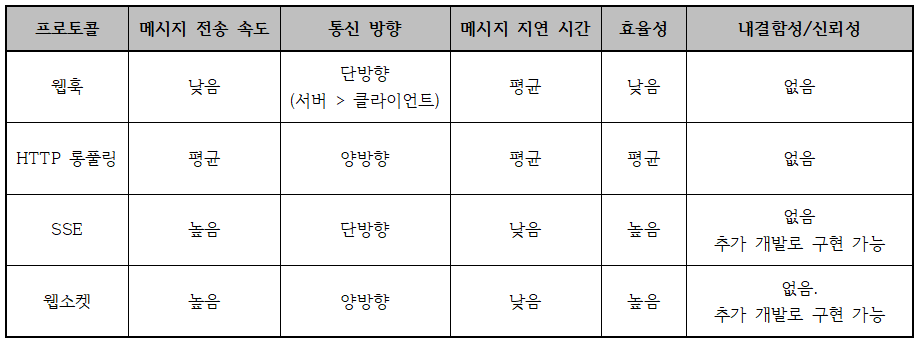

In [2]:
Image("C:/Users/jy990/Study/Streaming data/Image/7.1.PNG")

# 스트림 필터링

필터링은 출력되는 이벤트 중 클라이언트에서 필요한 데이터만 전달하는 것을 말한다. 필터링을 어디서 할건지(분석, 스트리밍, 클라이언트), 어떤 필터링을 할건지(정적, 동적)을 결정해야 한다.

### 필터링을 어디서 할건가

스트림 데이터를 취합하는 등의 알고리즘이 적용되려면 분석 단계에서 필터링이 수행되게 해야 한다. 분석 단계에서 하는게 쉽기 때문이다. 초당 이벤트 발생량이 엄청 적으면 스티리밍 API 단계에서 필터링 작업을 하는 것도 고려할 수는 있으나, 복잡해질거같으면 분석 단계로 옮기는 게 낫다.  

SQL이 동작하는 방식과 유사한 필터링은 RDBMS에서 테이블을 스트림으로 치환해 보면 된다.

### 정적 필터링 vs 동적 필터링

정적 필터링은 스트림에서 필터링될 내용을 미리 결정하고 처리하는 것이다. 이를 Out of the box 스트림 데이터라고 부르기도 한다. RDBMS에서의 View와 비슷하게, 설계자만 필터링 조건을 변경할 수 있고 클라이언트는 할 수 없다.  

동절 필터링은 런타임 애플리케이션에서 필터링이 결정되는 것이다. 스트리밍 클라이언트가 필터링을 수행하는 것이다. RDBMS 관점에서 동적 필터링은 특정 테이블에 쿼리를 실행하는 것과 비슷하다.

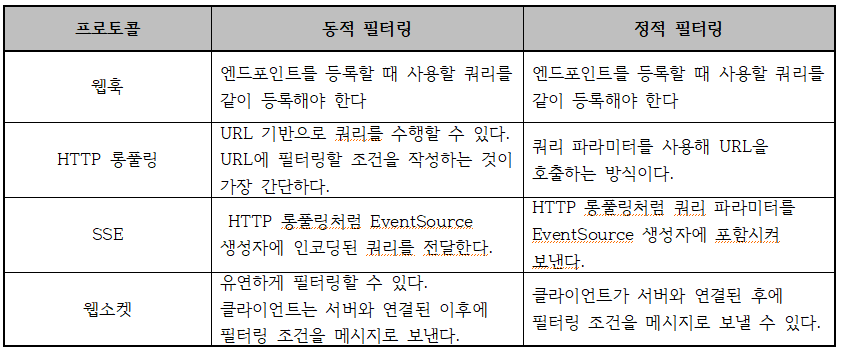

In [3]:
Image("C:/Users/jy990/Study/Streaming data/Image/7.2.PNG")

각 프로토콜이 2가지 방법의 필터링을 구현할 수 있다. 주요 차이점은 필터링을 얼마나 유연하게 구현하느냐이다. 많은 개발자가 SQL에 익숙하다는 점을 유의하자. API를 구축하고 필터링 설계로 SQL과 같은 구문을 채택할 수 있는 방법을 고려해야 한다. 스트리밍 API에 SQL과 같은 쿼리 기능을 추가하는 방법은 다양하다. JVM 기반 언어를 사용하여 파이프라인을 구축하는 경우에는 Calcite를 사용하는 등이다.